# TM10007 Assignment template

In [3]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [19]:
#Load packages

import pandas as pd
import numpy as np
import matplotlib as plt 

from sklearn.decomposition import PCA
from sklearn import datasets as ds
from sklearn import metrics
from sklearn import model_selection

# Classifiers --> later bijwerken welke we gebruiken
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


# Importing Data loading functions. Uncomment the one you want to use
from worcliver.load_data import load_data

from scipy.stats import ttest_ind, mannwhitneyu, shapiro
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score

In [20]:
# Loading the data
data = load_data()

# Presentation of the data:

In [60]:
# Description of the data
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Display basic info
print("First five rows of the dataset:")
print(data.head(), "\n")

print("Dataset info:")
print(data.info(), "\n")

print("Summary statistics:")
print(data.describe(), "\n")

# Counting missing values
missing_values = data.isnull().sum()
total_missing = missing_values.sum()

print(f"Total missing values in the dataset: {total_missing}\n")
print(f"Missing values per column:\n{missing_values[missing_values > 0]}\n")

# Counting categorical and numerical columns
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(exclude=['object']).columns

print(f"Number of categorical columns: {len(categorical_columns)}")
print(f"Number of numerical columns: {len(numerical_columns)}\n")

# Count of each label (benign/malignant)
label_counts = data['label'].value_counts()

print("Label distribution:")
print(label_counts)


The number of samples: 186
The number of columns: 494
First five rows of the dataset:
                 label  PREDICT_original_sf_compactness_avg_2.5D  \
ID                                                                 
Liver-001_0     benign                                  0.878471   
Liver-002_0     benign                                  0.878945   
Liver-003_0     benign                                  0.766162   
Liver-004_0  malignant                                  0.825737   
Liver-005_0  malignant                                  0.828831   

             PREDICT_original_sf_compactness_std_2.5D  \
ID                                                      
Liver-001_0                                  0.023468   
Liver-002_0                                  0.039922   
Liver-003_0                                  0.064140   
Liver-004_0                                  0.062047   
Liver-005_0                                  0.062635   

             PREDICT_original_sf_rad_

# Visualization of features

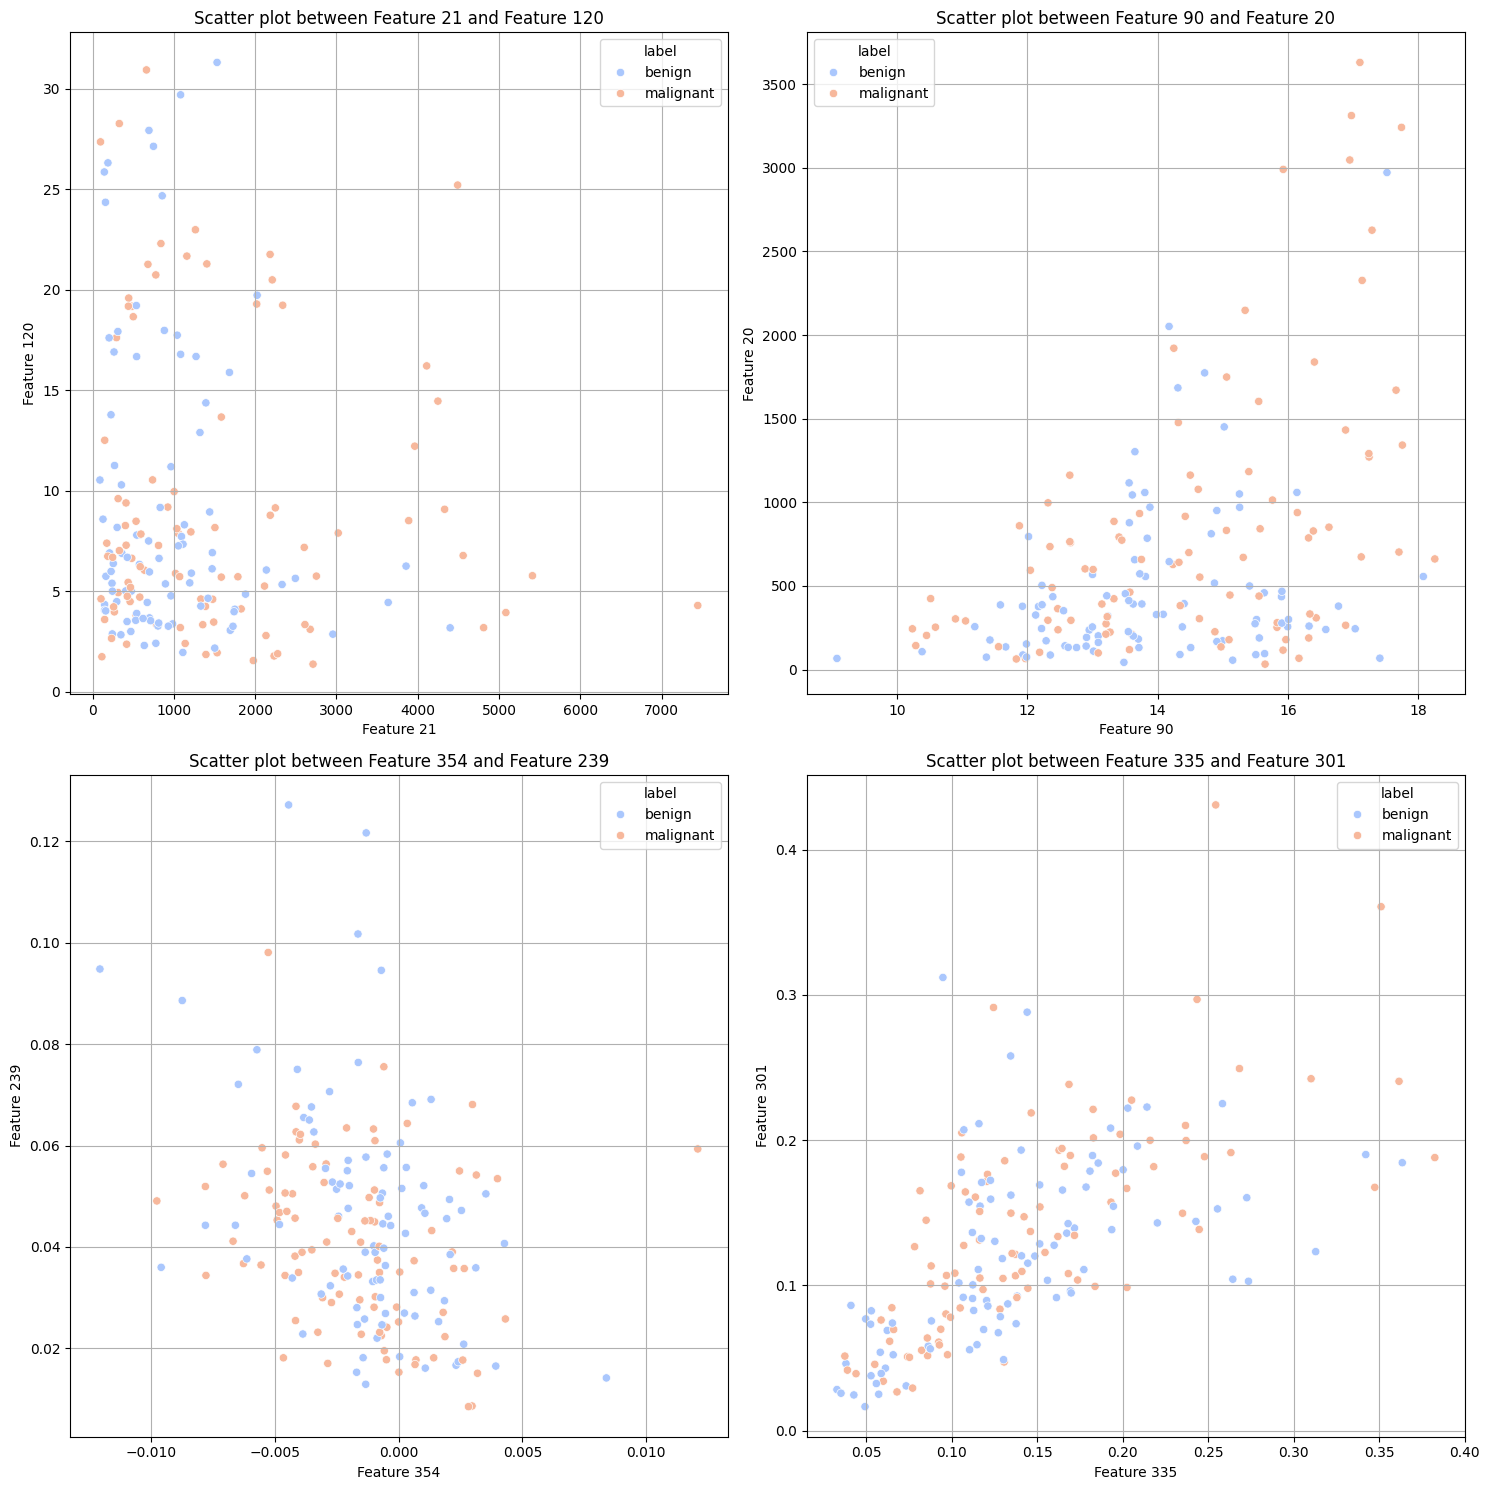

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# For loop with a 4 subplots in which 2 features are put against eachother to visualize the data
fig = plt.figure(figsize=(15, 15))

for i in range(4):
    random_columns = np.random.choice(data.columns[:-1], size=2, replace=False)
    
    # Use the index number of the feature for the title
    feature_num1 = list(data.columns).index(random_columns[0]) + 1  # Adding 1 to make it human-readable (starting from 1)
    feature_num2 = list(data.columns).index(random_columns[1]) + 1  # Adding 1 to make it human-readable (starting from 1)
    
    ax = fig.add_subplot(2, 2, i + 1)  # Manually creating subplots (2 rows, 2 columns)
    sns.scatterplot(x=data[random_columns[0]], y=data[random_columns[1]], hue=data['label'], palette='coolwarm', ax=ax)
    ax.set_title(f"Scatter plot between Feature {feature_num1} and Feature {feature_num2}")
    ax.set_xlabel(f"Feature {feature_num1}")
    ax.set_ylabel(f"Feature {feature_num2}")
    ax.grid(True)

plt.tight_layout()
plt.show()



# Changing labels malignant and benign to 0 and 1

In [25]:
#changing string (malignant or benign) to 0 or 1
num_data = data.copy()

# Transform labels: benign -> 1, malignant -> 0
num_data['label'] = num_data['label'].map({'benign': 1, 'malignant': 0})

# Splitting data in train and test test

In [27]:
#Splitting data in test and train set 
y = num_data['label']
x = num_data[:]

#x is features, y  = maligne / benign
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

#print the shape of the data sets  
print(f'The shape of the train data: {x_train.shape}')
print(f'The shape of the test data: {x_test.shape}')

x_train.to_csv('x_train.csv', index=False) 
x_test.to_csv('x_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False) 
y_test.to_csv('y_test.csv', index=False)




The shape of the train data: (148, 494)
The shape of the test data: (38, 494)


# Selecting significant features

In [98]:
# Select significant features
# Add the label column back to x_train
x_train_with_label = x_train.copy()
x_train_with_label['label'] = y_train

# Separate benign and malignant samples in training data
benign = x_train_with_label[x_train_with_label['label'] == 1]
malignant = x_train_with_label[x_train_with_label['label'] == 0]

x_train_with_label.to_csv('x_train_label.csv', index=False) 
# Perform statistical analysis
features = []
sig_features = []

# Loop through all features except 'label'
for feature in x_train_with_label.columns:
    if feature == 'label':  # Skip the label column
        continue
        
    # Data for current feature
    benign_values = benign[feature].dropna()
    malignant_values = malignant[feature].dropna()
    
    # Normality test (Shapiro-Wilk test, p < 0.05 means not normally distributed)
    _, p_benign = shapiro(benign_values)
    _, p_malignant = shapiro(malignant_values)
    
    # Determine which test to use
    if p_benign > 0.05 and p_malignant > 0.05:  # Both distributions are normal
        test_type = "t-test"
        stat, p_value = ttest_ind(benign_values, malignant_values, equal_var=False)  # Welch's t-test
    else:
        test_type = "Mann-Whitney U-test"
        stat, p_value = mannwhitneyu(benign_values, malignant_values, alternative='two-sided')
    
    # Save results
    feature_entry = {
        "Feature": feature,
        "Test": test_type,
        "p_value": p_value
    }
    features.append(feature_entry)
    
    # Check for significance (p <= 0.05)
    if p_value <= 0.05:
        sig_entry = feature_entry.copy()
        # sig_entry['benign_mean'] = benign_values.mean()
        # sig_entry['malignant_mean'] = malignant_values.mean()
        # sig_entry['benign_std'] = benign_values.std()
        # sig_entry['malignant_std'] = malignant_values.std()
        sig_features.append(sig_entry)

# Convert to DataFrames
features_df = pd.DataFrame(features)
sig_features_df = pd.DataFrame(sig_features)

# Multiple testing correction (False Discovery Rate - Benjamini-Hochberg)
if not features_df.empty:
    reject, p_corrected, alphacSidak, alphacBonf = multipletests(features_df["p_value"], method='fdr_bh')
    features_df["p_value_corrected"] = p_corrected

# Sort significant features by p-value only if there are significant features
if not sig_features_df.empty:
    sig_features_df = sig_features_df.sort_values(by="p_value")

# Print and save results
# print("\nTotal Significant Features:")
# print(sig_features_df)
print(f"\nNumber of significant features: {len(sig_features_df)}")

# Get the list of significant feature names
sig_feature_names = sig_features_df['Feature'].tolist() if not sig_features_df.empty else []

# Select only significant features for training data if there are any
if sig_feature_names:
    x_train_sig = x_train[sig_feature_names].copy()
    # Save results to CSV
    x_train_sig.to_csv('x_train_sig.csv', index=False)
else:
    print("No significant features found. Cannot create x_train_sig.")

# Save results to CSV
# features_df.to_csv('features.csv', index=False)
sig_features_df.to_csv('sig_features_df.csv', index=False)

c:\Users\ellen\Nieuwe_map\envs\KT-2023\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "



Number of significant features: 154


# Linear classifier

In [26]:
# Linear classifier
# Test how many feautures are normal distributed and covariances equal (p > 0.05)

#From features_df, sum how many t test used, i.e. are normal distributed from all features
normal_distributed = features_df.loc[features_df['Test'] == 't-test', 'Test'].count() 
print(f' The ammount of normal distributed features is: {normal_distributed}')

#the ammount of normal distibuted from significant features 
normal_distributed_sig = sig_features_df.loc[features_df['Test'] == 't-test', 'Test'].count() 
normal_distributed_non_sig = normal_distributed - normal_distributed_sig
print(f' The ammount of normal distributed features (p>0.05) {normal_distributed_non_sig}')

#Percentage of usable featrues for lineair classifier
print(f' Percentages of usable features for lineair classifier: {normal_distributed_non_sig/(len(data.columns))*100}')


#hier wordt de lineaire classif gemaakt, bepalen of we dat willen met 52
lda = LinearDiscriminantAnalysis()
lda = lda.fit(x_train, y_train)
y_pred_lda = lda.predict(x_test)


 The ammount of normal distributed features is: 77
 The ammount of normal distributed features (p>0.05) 39
 Percentages of usable features for lineair classifier: 7.894736842105263


# Quadratic classifier

In [17]:
# Quadratic classifier
# Test how many feautures are normal distributed and covariances not equal (p < 0.05)

#From features_df, sum how many t test used, i.e. are normal distributed from all features
normal_distributed = features_df.loc[features_df['Test'] == 't-test', 'Test'].count() 
print(f' The ammount of normal distributed features is: {normal_distributed}')

#the ammount of normal distibuted from non significant features 
normal_distributed_sig = sig_features_df.loc[features_df['Test'] == 't-test', 'Test'].count() 
print(f' The ammount of normal distributed features (p < 0.05) is: {normal_distributed_sig}')

#Percentage of usable featrues for quadratic classifier
print(f' Percentages of usable features for lineair classifier: {normal_distributed_sig/(len(data.columns))*100}')

# quadratic uitvoeren, later wss weg
#q_clas = QuadraticDiscriminantAnalysis()
#q_clas = q_clas.fit(x_train, y_train)
#q_clas_pred = q_clas.predict(x_test)

 The ammount of normal distributed features is: 77
 The ammount of normal distributed features (p < 0.05) is: 38
 Percentages of usable features for lineair classifier: 7.6923076923076925


# Voorbeeld functie loss funcite (voor lda) --> niet werkend op lda, code later aanpassen

In [ ]:
#for lda, X1, Y1 in zip(lda, x_train, y_train):
auc=metrics.roc_auc_score(y_train, y_pred_lda)
accuracy=metrics.accuracy_score(y_train, y_pred_lda)
F1=metrics.f1_score(y_train,y_pred_lda)
precision=metrics.precision_score(y_train,y_pred_lda)
recall=metrics.recall_score(y_train, y_pred_lda)

    # accuracy, AUC, f1score, precision, recall
print(type(lda))
print('Acc:' +str(accuracy))
print('AUC:' +str(auc))
print('F1:' +str(F1))
print('precision:' +str(precision))
print('recall:' +str(recall))

for learning_rate in [0.001, 0.01, 0.1, 0.5]:

    print(f"Training with learning rate {learning_rate}")
    print("Training set score: %f" % lda.score(x_train, y_train))
    print("Test set score: %f" % lda.score(x_test, y_test))

    plt.plot(lda.loss_curve_, label=f'lr = {learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
plt.legend()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [148, 38]

# Random forest classifier

In [143]:
# random forest code
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=10, criterion='gini', min_samples_split=2)
#rf.fit(x_train, y_train)
validation_rf = cross_val_score(estimator=rf, X=x_train, y=y_train, cv= 4)
print(validation_rf)

[0.83783784 0.78378378 0.81081081 0.64864865]


# Calculate mean and std of individual classes

In [18]:
#Decription 
## Dit nog aanpassen naar berekenen op basis van 'label' ipv deze nieuwe csv files
# Mean
benign_mean = benign.mean(numeric_only=True)
malignant_mean = malignant.mean(numeric_only=True)

# Standard deviation
benign_std = benign.std(numeric_only=True)
malignant_std = malignant.std(numeric_only=True)

#Print statistics
benign_stats = pd.DataFrame({
    'mean': benign.mean(numeric_only=True),
    'std': benign.std(numeric_only=True)
})
print(benign_stats)
benign_stats.T.to_csv('benign_stats.csv')


malignant_stats = pd.DataFrame({
    'mean': malignant.mean(numeric_only=True),
    'std': malignant.std(numeric_only=True)
})
malignant_stats.T.to_csv('malignant_stats.csv')

                                                          mean          std
label                                                 1.000000     0.000000
PREDICT_original_sf_compactness_avg_2.5D              0.810147     0.077220
PREDICT_original_sf_compactness_std_2.5D              0.066376     0.050309
PREDICT_original_sf_rad_dist_avg_2.5D                28.506844    12.658553
PREDICT_original_sf_rad_dist_std_2.5D                 4.475117     2.573123
...                                                        ...          ...
PREDICT_original_phasef_phasesym_peak_position_...    0.000000     0.000000
PREDICT_original_phasef_phasesym_range_WL3_N5         0.429725     0.106987
PREDICT_original_phasef_phasesym_energy_WL3_N5      709.573837  1157.150564
PREDICT_original_phasef_phasesym_quartile_range...    0.086281     0.094606
PREDICT_original_phasef_phasesym_entropy_WL3_N5      11.905744     1.959428

[494 rows x 2 columns]


# k-NN Classifier

In [ ]:
# Checking skewness for each feature in the training set in order to choose the scaler
skewness = x_train.skew()

# Printing the skewness for each feature
print("Skewness of features:")
print(skewness)

# Identifying features that have skewness greater than 1 or less than -1 (highly skewed)
skewed_features = skewness[abs(skewness) > 1].index
print("\nHighly skewed features (Skewness > 1 or < -1):")
print(skewed_features)

# Checking for outliers using Z-scores (Threshold: Z > 3 or Z < -3)
z_scores = np.abs(zscore(x_train))

# Identifying features with Z-scores above the threshold (outliers)
outliers = (z_scores > 3)

# Getting the feature names where outliers exist
outlier_features = x_train.columns[(outliers.any(axis=0))].tolist()
print("\nFeatures with outliers (Z-score > 3):")
print(outlier_features)

# Optionally, calculate the IQR for outlier detection
Q1 = x_train.quantile(0.25)
Q3 = x_train.quantile(0.75)
IQR = Q3 - Q1

# Detecting outliers based on IQR
outliers_iqr = ((x_train < (Q1 - 1.5 * IQR)) | (x_train > (Q3 + 1.5 * IQR)))

# Getting feature names with IQR outliers
outlier_features_iqr = x_train.columns[(outliers_iqr.any(axis=0))].tolist()
print("\nFeatures with outliers based on IQR:")
print(outlier_features_iqr)

# Making the classifier

# Define the pipeline
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

# Define hyperparameter grid
param_grid = {
    'pca__n_components': [5, 10, 15, 20, 25],
    'knn__n_neighbors': list(range(1, 31, 2)),  # Odd k values from 1 to 29
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Perform hyperparameter optimization
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)

# Print best parameters and test accuracy
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test Accuracy: {test_accuracy:.4f}")

### PLOT 1: Learning Curve (Apparent vs. True Error)
best_k = grid_search.best_params_['knn__n_neighbors']
best_pca = grid_search.best_params_['pca__n_components']

# Define the final best pipeline
pipeline = Pipeline([
    ('scaler', RobustScaler()),  
    ('pca', PCA(n_components=best_pca)),  
    ('knn', KNeighborsClassifier(n_neighbors=best_k, metric='euclidean', weights='uniform'))
])

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    pipeline, x_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Convert accuracy to error (1 - accuracy)
train_error = 1 - train_mean
val_error = 1 - val_mean

# Plot Apparent Error (Training) vs True Error (Validation)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_error, marker='o', color='blue', label='Apparent Error (Training)')
plt.plot(train_sizes, val_error, marker='o', color='red', label='True Error (Validation)')
plt.fill_between(train_sizes, train_error - train_std, train_error + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_error - val_std, val_error + val_std, color='red', alpha=0.2)

# Labels and Title
plt.xlabel('Training Set Size')
plt.ylabel('Error (1 - Accuracy)')
plt.title('Learning Curve: Apparent vs. True Error')
plt.legend()
plt.grid(True)
plt.show()

### PLOT 2: Accuracy vs. k
k_values = list(range(1, 31, 2))  # Odd k values from 1 to 29
train_accuracies = []
val_accuracies = []

# Loop through different k values
for k in k_values:
    # Define the pipeline with current k
    pipeline = Pipeline([
        ('scaler', RobustScaler()),  
        ('pca', PCA(n_components=best_pca)),  
        ('knn', KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='uniform'))
    ])
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, x_train, y_train, cv=5, scoring='accuracy')
    
    # Fit on training data to get training accuracy
    pipeline.fit(x_train, y_train)
    train_accuracy = accuracy_score(y_train, pipeline.predict(x_train))

    # Store accuracies
    train_accuracies.append(train_accuracy)
    val_accuracies.append(scores.mean())

# Plot training vs validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, marker='o', linestyle='-', label='Training Accuracy', color='blue')
plt.plot(k_values, val_accuracies, marker='o', linestyle='-', label='Validation Accuracy', color='red')

# Labels and Title
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. k for k-NN Classifier")
plt.legend()
plt.grid(True)
plt.show()
